In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, avg
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# Initialize Spark Session

spark = SparkSession.builder.appName("movie-ratings").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/04 14:27:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/04 14:27:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
# Load the data

file_path = "movie_data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [6]:
# Show the schema

df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- director_name: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- actor_2_name: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- actor_1_name: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- num_voted_users: integer (nullable = true)
 |-- actor_3_name: string (nullable = true)
 |-- movie_imdb_link: string (nullable = true)
 |-- num_user_for_reviews: double (nullable = true)
 |-- language: string (nullable = true)
 |-- country: string (nullable = true)
 |-- title_year: double (nullable = true)
 |-- imdb_score: double (nullable = true)



# Exploratory Data Analysis (EDA)

In [7]:
# Display the first few rows

df.show(5)

+-----+-----------------+--------+----------------+--------------------+---------------+--------------------+---------------+--------------------+--------------------+--------------------+--------+-------+----------+----------+
|index|    director_name|duration|    actor_2_name|              genres|   actor_1_name|         movie_title|num_voted_users|        actor_3_name|     movie_imdb_link|num_user_for_reviews|language|country|title_year|imdb_score|
+-----+-----------------+--------+----------------+--------------------+---------------+--------------------+---------------+--------------------+--------------------+--------------------+--------+-------+----------+----------+
|    0|    James Cameron|   178.0|Joel David Moore|Action|Adventure|...|    CCH Pounder|             Avatar |         886204|           Wes Studi|http://www.imdb.c...|              3054.0| English|    USA|    2009.0|       7.9|
|    1|   Gore Verbinski|   169.0|   Orlando Bloom|Action|Adventure|...|    Johnny Depp|

In [8]:
# Summary statistics

df.describe().show()

24/08/04 14:27:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/08/04 14:27:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-------------+-----------------+-------------+-------+-------------+-----------+-----------------+-------------+--------------------+--------------------+----------+------------+------------------+------------------+
|summary|             index|director_name|         duration| actor_2_name| genres| actor_1_name|movie_title|  num_voted_users| actor_3_name|     movie_imdb_link|num_user_for_reviews|  language|     country|        title_year|        imdb_score|
+-------+------------------+-------------+-----------------+-------------+-------+-------------+-----------+-----------------+-------------+--------------------+--------------------+----------+------------+------------------+------------------+
|  count|              5043|         4939|             5028|         5030|   5043|         5036|       5043|             5043|         5020|                5043|                5022|      5031|        5038|              4935|              5043|
|   mean|           

In [9]:
# Check for missing values

missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+-----+-------------+--------+------------+------+------------+-----------+---------------+------------+---------------+--------------------+--------+-------+----------+----------+
|index|director_name|duration|actor_2_name|genres|actor_1_name|movie_title|num_voted_users|actor_3_name|movie_imdb_link|num_user_for_reviews|language|country|title_year|imdb_score|
+-----+-------------+--------+------------+------+------------+-----------+---------------+------------+---------------+--------------------+--------+-------+----------+----------+
|    0|          104|      15|          13|     0|           7|          0|              0|          23|              0|                  21|      12|      5|       108|         0|
+-----+-------------+--------+------------+------+------------+-----------+---------------+------------+---------------+--------------------+--------+-------+----------+----------+



In [10]:
# Convert to Pandas for visualization

pdf = df.toPandas()

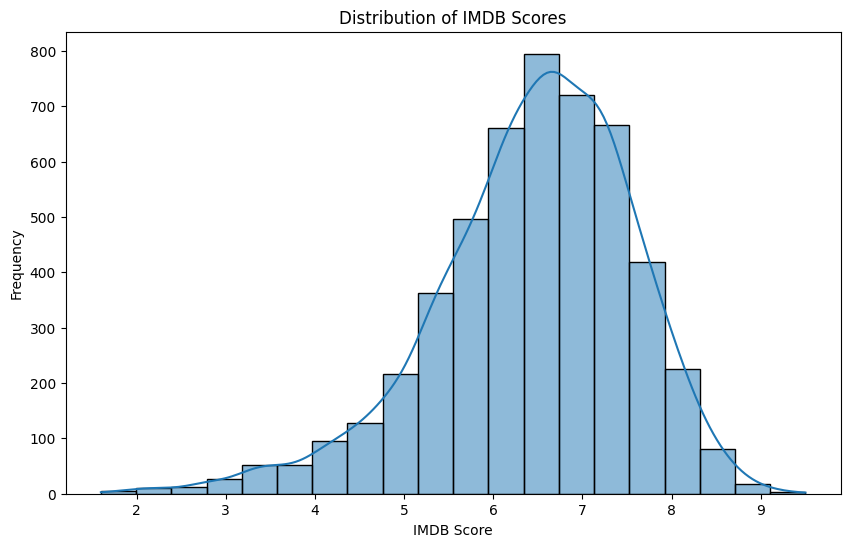

In [11]:
# Plot distribution of imdb_score

plt.figure(figsize=(10, 6))
sns.histplot(pdf['imdb_score'], bins=20, kde=True)
plt.title('Distribution of IMDB Scores')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.show()

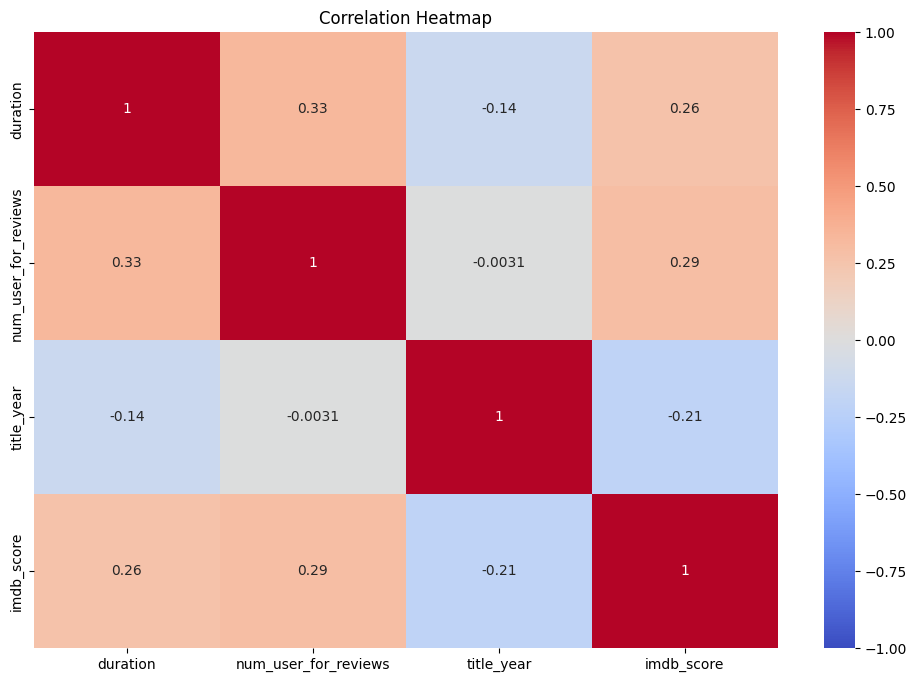

In [13]:
# Select only numeric columns for correlation heatmap

numeric_cols = pdf.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
corr = pdf[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


# Data Preprocessing

In [14]:
# Drop rows with missing values

df = df.dropna()

In [15]:
# Convert categorical columns to numerical using StringIndexer and OneHotEncoder

indexers = [StringIndexer(inputCol=column, outputCol=column + "Index") for column in ["director_name", "actor_1_name", "actor_2_name", "actor_3_name", "genres", "language", "country"]]
encoders = [OneHotEncoder(inputCol=column + "Index", outputCol=column + "Vec") for column in ["director_name", "actor_1_name", "actor_2_name", "actor_3_name", "genres", "language", "country"]]

In [16]:
for indexer in indexers:
    df = indexer.fit(df).transform(df)

for encoder in encoders:
    df = encoder.fit(df).transform(df)

# Feature Engineering

In [17]:
# Assemble features into a single vector

assembler = VectorAssembler(inputCols=["duration", "num_voted_users", "num_user_for_reviews", "title_year"] +
                                       [column + "Vec" for column in ["director_name", "actor_1_name", "actor_2_name", "actor_3_name", "genres", "language", "country"]],
                            outputCol="features")
df = assembler.transform(df)

In [18]:
# Standardize the features

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

24/08/04 14:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1443.9 KiB
24/08/04 14:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1431.6 KiB


In [25]:
# Split data into training and test sets

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Build and Evaluate Models

In [26]:
# Initialize models

lr = LinearRegression(featuresCol="scaledFeatures", labelCol="imdb_score")
dt = DecisionTreeRegressor(featuresCol="scaledFeatures", labelCol="imdb_score")
rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="imdb_score")

In [27]:
# Hyperparameter tuning and cross-validation

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .build()

paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .build()

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()

In [28]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="imdb_score", metricName="rmse")

In [29]:
crossval_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator, numFolds=3)
crossval_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator, numFolds=3)
crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator, numFolds=3)

In [30]:
# Train models

cv_model_lr = crossval_lr.fit(train_data)
cv_model_dt = crossval_dt.fit(train_data)
cv_model_rf = crossval_rf.fit(train_data)

24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:31:58 WARN DAGScheduler: Broadcasting larg

In [31]:
# Make predictions

predictions_lr = cv_model_lr.transform(test_data)
predictions_dt = cv_model_dt.transform(test_data)
predictions_rf = cv_model_rf.transform(test_data)

In [32]:
# Model Evaluation

rmse_lr = evaluator.evaluate(predictions_lr)
rmse_dt = evaluator.evaluate(predictions_dt)
rmse_rf = evaluator.evaluate(predictions_rf)

24/08/04 14:35:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/04 14:35:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/08/04 14:35:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [33]:
print(f"Root Mean Squared Error (RMSE) for Linear Regression = {rmse_lr}")
print(f"Root Mean Squared Error (RMSE) for Decision Tree = {rmse_dt}")
print(f"Root Mean Squared Error (RMSE) for Random Forest = {rmse_rf}")

Root Mean Squared Error (RMSE) for Linear Regression = 0.9446273613966282
Root Mean Squared Error (RMSE) for Decision Tree = 0.8957836080947658
Root Mean Squared Error (RMSE) for Random Forest = 0.8979734093786075


# Feature Importances

In [38]:
# Feature Importance for Decision Tree and Random Forest

importances_dt = cv_model_dt.bestModel.featureImportances
importances_rf = cv_model_rf.bestModel.featureImportances
feature_names = ["duration", "num_voted_users", "num_user_for_reviews", "title_year"] + \
                [column + "Vec" for column in ["director_name", "actor_1_name", "actor_2_name", "actor_3_name", "genres", "language", "country"]]

In [39]:
print("Feature Importances for Decision Tree:")
for i, imp in enumerate(importances_dt):
    print(f"Feature {i}: {imp}")

Feature Importances for Decision Tree:
Feature 0: 0.12712902888346123
Feature 1: 0.4299033094901424
Feature 2: 0.030189492693040956
Feature 3: 0.10413229143261248
Feature 4: 2.7128609786666632e-06
Feature 5: 0.0
Feature 6: 0.0
Feature 7: 4.464594067633703e-05
Feature 8: 0.0
Feature 9: 0.0
Feature 10: 0.0
Feature 11: 0.0
Feature 12: 0.0
Feature 13: 0.0
Feature 14: 0.0
Feature 15: 0.0
Feature 16: 4.689373977289441e-05
Feature 17: 0.0
Feature 18: 0.0
Feature 19: 0.0
Feature 20: 0.0
Feature 21: 0.0
Feature 22: 0.0
Feature 23: 0.0
Feature 24: 0.00037825135060187253
Feature 25: 0.0
Feature 26: 0.0
Feature 27: 0.0
Feature 28: 0.0
Feature 29: 0.000601241667877764
Feature 30: 0.0
Feature 31: 0.0
Feature 32: 2.4415748807511324e-05
Feature 33: 0.0
Feature 34: 0.0
Feature 35: 0.0
Feature 36: 0.0
Feature 37: 0.0006626058599409706
Feature 38: 1.775690822352527e-05
Feature 39: 0.0
Feature 40: 0.0
Feature 41: 0.0
Feature 42: 8.400180244430962e-05
Feature 43: 0.0
Feature 44: 0.0
Feature 45: 0.003987163

In [53]:
print("Feature Importances for Random Forest:")
for i, imp in enumerate(importances_rf):
    print(f"Feature {i}: {imp}")

Feature Importances for Random Forest:
Feature 0: 0.2043712160637315
Feature 1: 0.43386392355780873
Feature 2: 0.07834013877783738
Feature 3: 0.08030249068140019
Feature 4: 6.588175841995177e-05
Feature 5: 0.0006899198585746327
Feature 6: 0.0
Feature 7: 0.0
Feature 8: 0.0
Feature 9: 0.0
Feature 10: 0.0
Feature 11: 1.829200633144991e-05
Feature 12: 0.0
Feature 13: 0.0
Feature 14: 0.0
Feature 15: 0.0006393417060371213
Feature 16: 0.0
Feature 17: 3.958664508921946e-05
Feature 18: 0.0
Feature 19: 0.0
Feature 20: 0.0
Feature 21: 0.0
Feature 22: 0.0
Feature 23: 0.0
Feature 24: 0.0
Feature 25: 0.0
Feature 26: 0.0
Feature 27: 0.0
Feature 28: 0.0
Feature 29: 0.0
Feature 30: 0.00010125070007979521
Feature 31: 0.0
Feature 32: 0.0
Feature 33: 0.0
Feature 34: 0.0
Feature 35: 0.0
Feature 36: 0.0
Feature 37: 0.0
Feature 38: 0.0
Feature 39: 6.832362027286898e-06
Feature 40: 0.0
Feature 41: 0.0
Feature 42: 0.0
Feature 43: 0.0
Feature 44: 0.0
Feature 45: 0.00026080766659859354
Feature 46: 0.000231317569

In [59]:
# Stopping the Spark session
spark.stop()